In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
df_data = pd.read_csv('ozone_eighthr.csv') # 读取数据
df_data.replace(['?'],[-999], inplace =True) # 用-999替换？
df_data.fillna(-999, inplace =True) #用-999填充空的地方
df_data.columns # 特征名称如下

Index(['Date', 'WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7',
       'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15',
       'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23',
       'WSR_PK', 'WSR_AV', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7',
       'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17',
       'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T_PK', 'T_AV', 'T85', 'RH85',
       'U85', 'V85', 'HT85', 'T70', 'RH70', 'U70', 'V70', 'HT70', 'T50',
       'RH50', 'U50', 'V50', 'HT50', 'KI', 'TT', 'SLP', 'SLP_', 'Precp',
       'Orzone'],
      dtype='object')

In [3]:
label = df_data.pop('Orzone').values # label
df_data.pop('Date')
data = df_data.values # features
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=999) #训练集、验证机切分

# different models

AUC of lgb is: 0.9427506775067751
AUC of RF is: 0.8548780487804879
AUC of tree is: 0.6792344173441734


/home/ming/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ming/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ming/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ming/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


AUC of LR is: 0.8161754742547426
AUC of SVM is: 0.553760162601626


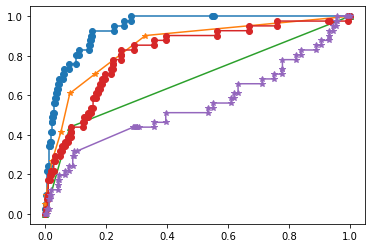

In [4]:
def train(model, model_name):
    model.fit(X_train, y_train) # 训练
    y_score = model.predict_proba(X_test)[:, 1] #预测
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score) #计算AUC index
    AUC = metrics.roc_auc_score(y_test,y_score) #计算AUC
    print('AUC of %s is: %s' %(model_name,AUC)) # 打印
    return fpr, tpr
  
# 定义模型
model1 = LGBMClassifier(boosting_type='gbdt', objective='binary')
model2 = RandomForestClassifier()
model3 = DecisionTreeClassifier()
model4 = LogisticRegression()  
model5 = SVC(probability=True)

# 下面依次调用上面的函数
fpr1, tpr1 = train(model1, 'lgb')
fpr2, tpr2 = train(model2, 'RF')
fpr3, tpr3 = train(model3, 'tree')
fpr4, tpr4 = train(model4, 'LR')
fpr5, tpr5 = train(model5, 'SVM')

# 画图
plt.plot(fpr1, tpr1, marker = 'o')
plt.plot(fpr2, tpr2, marker = '*')
plt.plot(fpr3, tpr3, marker = '^')
plt.plot(fpr4, tpr4, marker = 'o')
plt.plot(fpr5, tpr5, marker = '*')
plt.show()

LGB performs better than other methods, it is a boosting methods, and iterate over multiple weak models, on the other hand, each step is based on the residual error of the previous step, paying more attention to the accuracy rate.

# defferent parameter

1) different max_depth in LGB

In [5]:
L = []
R = []
auc = []
# 比较不同的 max_depth，分别取值3,4,5,6,7,8，训练、画图过程与上面类似
for depth in [3,4,5,6,7,8]:
    clf = LGBMClassifier(boosting_type='gbdt', 
                             objective='binary',
                             max_depth = depth
                        )  
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=10)  
    
    y_score = clf.predict_proba(X_test)[:, 1]
    L.append(metrics.roc_curve(y_test, y_score)[0])
    R.append(metrics.roc_curve(y_test, y_score)[1])
    auc.append(metrics.roc_auc_score(y_test,y_score))

[1]	valid_0's binary_logloss: 0.200003	valid_0's auc: 0.843801
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.19135	valid_0's auc: 0.868327
[3]	valid_0's binary_logloss: 0.185544	valid_0's auc: 0.881301
[4]	valid_0's binary_logloss: 0.180508	valid_0's auc: 0.886738
[5]	valid_0's binary_logloss: 0.175454	valid_0's auc: 0.893106
[6]	valid_0's binary_logloss: 0.172265	valid_0's auc: 0.895969
[7]	valid_0's binary_logloss: 0.1688	valid_0's auc: 0.899543
[8]	valid_0's binary_logloss: 0.166655	valid_0's auc: 0.902507
[9]	valid_0's binary_logloss: 0.164585	valid_0's auc: 0.903066
[10]	valid_0's binary_logloss: 0.162587	valid_0's auc: 0.904895
[11]	valid_0's binary_logloss: 0.159967	valid_0's auc: 0.90957
[12]	valid_0's binary_logloss: 0.158047	valid_0's auc: 0.912432
[13]	valid_0's binary_logloss: 0.157337	valid_0's auc: 0.910349
[14]	valid_0's binary_logloss: 0.156887	valid_0's auc: 0.90918
[15]	valid_0's binary_logloss: 0.154836	valid_0's auc: 0

[7]	valid_0's binary_logloss: 0.159662	valid_0's auc: 0.907622
[8]	valid_0's binary_logloss: 0.156347	valid_0's auc: 0.911822
[9]	valid_0's binary_logloss: 0.152634	valid_0's auc: 0.915176
[10]	valid_0's binary_logloss: 0.150923	valid_0's auc: 0.915075
[11]	valid_0's binary_logloss: 0.149839	valid_0's auc: 0.914228
[12]	valid_0's binary_logloss: 0.148694	valid_0's auc: 0.912907
[13]	valid_0's binary_logloss: 0.146148	valid_0's auc: 0.91582
[14]	valid_0's binary_logloss: 0.144796	valid_0's auc: 0.914668
[15]	valid_0's binary_logloss: 0.143699	valid_0's auc: 0.915617
[16]	valid_0's binary_logloss: 0.142898	valid_0's auc: 0.913381
[17]	valid_0's binary_logloss: 0.140804	valid_0's auc: 0.917852
[18]	valid_0's binary_logloss: 0.140935	valid_0's auc: 0.916023
[19]	valid_0's binary_logloss: 0.140117	valid_0's auc: 0.917852
[20]	valid_0's binary_logloss: 0.13894	valid_0's auc: 0.918259
[21]	valid_0's binary_logloss: 0.138915	valid_0's auc: 0.916396
[22]	valid_0's binary_logloss: 0.13847	valid_

[3]	valid_0's binary_logloss: 0.178648	valid_0's auc: 0.874983
[4]	valid_0's binary_logloss: 0.172568	valid_0's auc: 0.887331
[5]	valid_0's binary_logloss: 0.16642	valid_0's auc: 0.905403
[6]	valid_0's binary_logloss: 0.160703	valid_0's auc: 0.913499
[7]	valid_0's binary_logloss: 0.156086	valid_0's auc: 0.920105
[8]	valid_0's binary_logloss: 0.152759	valid_0's auc: 0.921985
[9]	valid_0's binary_logloss: 0.150665	valid_0's auc: 0.921748
[10]	valid_0's binary_logloss: 0.147255	valid_0's auc: 0.926016
[11]	valid_0's binary_logloss: 0.144582	valid_0's auc: 0.929167
[12]	valid_0's binary_logloss: 0.141739	valid_0's auc: 0.931301
[13]	valid_0's binary_logloss: 0.140307	valid_0's auc: 0.931673
[14]	valid_0's binary_logloss: 0.137869	valid_0's auc: 0.934722
[15]	valid_0's binary_logloss: 0.137116	valid_0's auc: 0.933909
[16]	valid_0's binary_logloss: 0.134978	valid_0's auc: 0.936382
[17]	valid_0's binary_logloss: 0.13468	valid_0's auc: 0.935095
[18]	valid_0's binary_logloss: 0.13401	valid_0's 

[0.9399051490514906, 0.9352642276422765, 0.9290650406504065, 0.9430216802168021, 0.9327574525745257, 0.9362804878048779]


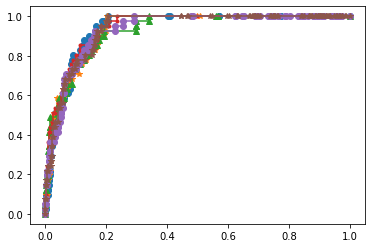

In [6]:
print(auc)
plt.plot(L[0], R[0], marker = 'o') 
plt.plot(L[1], R[1], marker = '*') 
plt.plot(L[2], R[2], marker = '^') 
plt.plot(L[3], R[3], marker = '.')
plt.plot(L[4], R[4], marker = 'o') 
plt.plot(L[5], R[5], marker = '*') 
plt.show()

With the increase of max_depth, auc decreases first, then increases, and then decreases again, indicating that this parameter will affect the effect of the model to some extent, and a value in the middle can make the model achieve the best effect.

2) different num_leaves in LGB

In [7]:
L = []
R = []
auc = []
# 比较不同的num_leaves
for num in [30, 50, 70, 90, 110]:
    clf = LGBMClassifier(boosting_type='gbdt', 
                             objective='binary',
                             num_leaves = num
                        )  
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=10)  
    
    y_score = clf.predict_proba(X_test)[:, 1]
    L.append(metrics.roc_curve(y_test, y_score)[0])
    R.append(metrics.roc_curve(y_test, y_score)[1])
    auc.append(metrics.roc_auc_score(y_test,y_score))

[1]	valid_0's binary_logloss: 0.194634	valid_0's auc: 0.804099
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.186127	valid_0's auc: 0.845867
[3]	valid_0's binary_logloss: 0.178646	valid_0's auc: 0.875017
[4]	valid_0's binary_logloss: 0.172581	valid_0's auc: 0.887534
[5]	valid_0's binary_logloss: 0.166717	valid_0's auc: 0.902625
[6]	valid_0's binary_logloss: 0.161396	valid_0's auc: 0.911094
[7]	valid_0's binary_logloss: 0.15678	valid_0's auc: 0.918716
[8]	valid_0's binary_logloss: 0.153821	valid_0's auc: 0.91958
[9]	valid_0's binary_logloss: 0.149599	valid_0's auc: 0.923984
[10]	valid_0's binary_logloss: 0.146969	valid_0's auc: 0.92544
[11]	valid_0's binary_logloss: 0.144292	valid_0's auc: 0.928862
[12]	valid_0's binary_logloss: 0.143309	valid_0's auc: 0.928862
[13]	valid_0's binary_logloss: 0.141657	valid_0's auc: 0.927575
[14]	valid_0's binary_logloss: 0.140378	valid_0's auc: 0.928049
[15]	valid_0's binary_logloss: 0.138187	valid_0's auc:

[23]	valid_0's binary_logloss: 0.130599	valid_0's auc: 0.938516
[24]	valid_0's binary_logloss: 0.130301	valid_0's auc: 0.938415
[25]	valid_0's binary_logloss: 0.130502	valid_0's auc: 0.937568
[26]	valid_0's binary_logloss: 0.13036	valid_0's auc: 0.938482
[27]	valid_0's binary_logloss: 0.131195	valid_0's auc: 0.937127
[28]	valid_0's binary_logloss: 0.129734	valid_0's auc: 0.938618
[29]	valid_0's binary_logloss: 0.12918	valid_0's auc: 0.939228
[30]	valid_0's binary_logloss: 0.128901	valid_0's auc: 0.939634
[31]	valid_0's binary_logloss: 0.128569	valid_0's auc: 0.939465
[32]	valid_0's binary_logloss: 0.129179	valid_0's auc: 0.938991
[33]	valid_0's binary_logloss: 0.128549	valid_0's auc: 0.939566
[34]	valid_0's binary_logloss: 0.128474	valid_0's auc: 0.939905
[35]	valid_0's binary_logloss: 0.127562	valid_0's auc: 0.942717
[36]	valid_0's binary_logloss: 0.127064	valid_0's auc: 0.943293
[37]	valid_0's binary_logloss: 0.127166	valid_0's auc: 0.94397
[38]	valid_0's binary_logloss: 0.126778	val

[0.932960704607046, 0.9467140921409214, 0.9467140921409214, 0.9467140921409214, 0.9467140921409214]


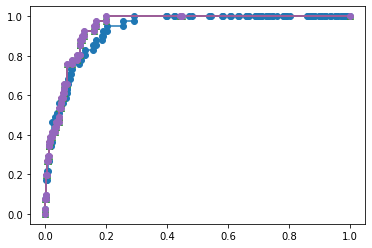

In [8]:
print(auc)
plt.plot(L[0], R[0], marker = 'o') 
plt.plot(L[1], R[1], marker = '*') 
plt.plot(L[2], R[2], marker = '^') 
plt.plot(L[3], R[3], marker = '.')
plt.plot(L[4], R[4], marker = 'o') 
plt.show()

As num_leaves increases, the auc decreases first, then increases, because the model fits better and better, then overfits.

3) different n_estimators in RF

In [9]:
L = []
R = []
auc = []

# 比较不同的n_estimators
for num in [100, 200, 300, 400, 500]:
    clf = RandomForestClassifier(n_estimators=num)
    clf.fit(X_train, y_train)  
    
    y_score = clf.predict_proba(X_test)[:, 1]
    L.append(metrics.roc_curve(y_test, y_score)[0])
    R.append(metrics.roc_curve(y_test, y_score)[1])
    auc.append(metrics.roc_auc_score(y_test,y_score))

[0.93755081300813, 0.9370088075880759, 0.9355352303523035, 0.9421917344173443, 0.9423272357723578]


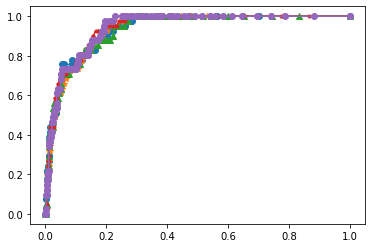

In [10]:
print(auc)
plt.plot(L[0], R[0], marker = 'o') 
plt.plot(L[1], R[1], marker = '*') 
plt.plot(L[2], R[2], marker = '^') 
plt.plot(L[3], R[3], marker = '.')
plt.plot(L[4], R[4], marker = 'o') 
plt.show()

With the increase of n_estimators, the auc first decreases, then increases, and then becomes stable, indicating that the model tends to be stable after the value of n_estimators is larger.

4) different bootstrap in RF

In [11]:
L = []
R = []
auc = []

# 比较RF不同的bootstrap
for bootstrap in [True, False]:
    clf = RandomForestClassifier(bootstrap=bootstrap)
    clf.fit(X_train, y_train)  
    
    y_score = clf.predict_proba(X_test)[:, 1]
    L.append(metrics.roc_curve(y_test, y_score)[0])
    R.append(metrics.roc_curve(y_test, y_score)[1])
    auc.append(metrics.roc_auc_score(y_test,y_score))

/home/ming/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ming/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.8393970189701896, 0.8635670731707318]


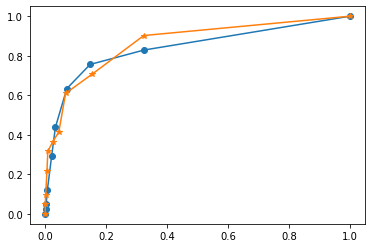

In [12]:
print(auc)
plt.plot(L[0], R[0], marker = 'o') 
plt.plot(L[1], R[1], marker = '*') 
plt.show()

From the model effect, the effect of sampling without replacement is better than that with replacement.

# defferent data split ratio

In [13]:
clf = LGBMClassifier(boosting_type='gbdt', objective='binary')

L = []
R = []
auc = []

# 比较不同的切分方式下，LGB的结果
for size in [0.3, 0.4,0.5, 0.6, 0.7]:
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=size, random_state=999)
    
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=10)  
    y_score = clf.predict_proba(X_test)[:, 1]
    L.append(metrics.roc_curve(y_test, y_score)[0])
    R.append(metrics.roc_curve(y_test, y_score)[1])
    auc.append(metrics.roc_auc_score(y_test,y_score))

[1]	valid_0's binary_logloss: 0.194634	valid_0's auc: 0.804099
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.186128	valid_0's auc: 0.846104
[3]	valid_0's binary_logloss: 0.178648	valid_0's auc: 0.874983
[4]	valid_0's binary_logloss: 0.172587	valid_0's auc: 0.8875
[5]	valid_0's binary_logloss: 0.166717	valid_0's auc: 0.902761
[6]	valid_0's binary_logloss: 0.161392	valid_0's auc: 0.911196
[7]	valid_0's binary_logloss: 0.156775	valid_0's auc: 0.918852
[8]	valid_0's binary_logloss: 0.153817	valid_0's auc: 0.919682
[9]	valid_0's binary_logloss: 0.149595	valid_0's auc: 0.923916
[10]	valid_0's binary_logloss: 0.146969	valid_0's auc: 0.92544
[11]	valid_0's binary_logloss: 0.144294	valid_0's auc: 0.928997
[12]	valid_0's binary_logloss: 0.143315	valid_0's auc: 0.928896
[13]	valid_0's binary_logloss: 0.141672	valid_0's auc: 0.927541
[14]	valid_0's binary_logloss: 0.140397	valid_0's auc: 0.927981
[15]	valid_0's binary_logloss: 0.138203	valid_0's auc:

[0.9324525745257453, 0.9220150690205137, 0.9345117527909935, 0.9182490113614964, 0.8811931586806026]


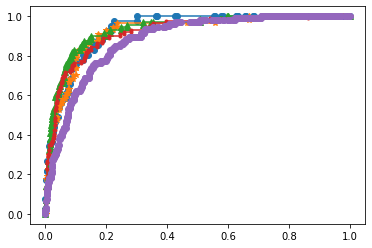

In [14]:
print(auc)
plt.plot(L[0], R[0], marker = 'o') 
plt.plot(L[1], R[1], marker = '*') 
plt.plot(L[2], R[2], marker = '^') 
plt.plot(L[3], R[3], marker = '.')
plt.plot(L[4], R[4], marker = 'o') 
plt.show()

With the increase of test_size, the overall trend of AUC is decreased, because less and less data are used for training, and the generalization ability of the model is decreased.

In [15]:
clf = RandomForestClassifier()

L = []
R = []
auc = []

# 比较不同的切分方式下，RF的结果
for size in [0.3, 0.4,0.5, 0.6, 0.7]:
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=size, random_state=999)
    
    clf.fit(X_train, y_train)  
    y_score = clf.predict_proba(X_test)[:, 1]
    L.append(metrics.roc_curve(y_test, y_score)[0])
    R.append(metrics.roc_curve(y_test, y_score)[1])
    auc.append(metrics.roc_auc_score(y_test,y_score))

/home/ming/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.821460027100271, 0.8997873471557681, 0.8477672052381177, 0.8535834222584897, 0.8047571376860775]


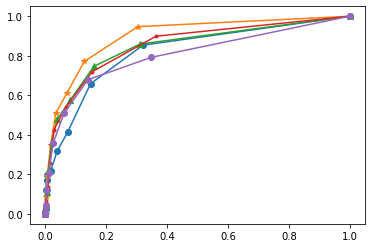

In [16]:
print(auc)
plt.plot(L[0], R[0], marker = 'o') 
plt.plot(L[1], R[1], marker = '*') 
plt.plot(L[2], R[2], marker = '^') 
plt.plot(L[3], R[3], marker = '.')
plt.plot(L[4], R[4], marker = 'o') 
plt.show()

The effect of the model is the same as that of XGB, and the generalization ability of the model is weakened due to the reduction of training data.